<a href="https://colab.research.google.com/github/GruAna/VU/blob/master/m_EasyOCR1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EasyOCR

## Packages

In [1]:
!pip install easyocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 70.8 MB 15 kB/s 
     |████████████████████████████████| 47.6 MB 1.2 MB/s 


In [2]:
import easyocr
import os
import cv2 as cv
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cp drive/MyDrive/Colab_Notebooks/VU/utils.py .
from utils import *

## Setup

In [5]:
# if GPU is to be used, allow CUDA
use_GPU = True  # False

# whether images are to be resized (skrinking)
resize = True
width = 3000

## Dataset loading

**CTW1500 dataset**

Get images. Update location of images **manually**.

In [6]:
# path to image directory, get full path to all files
imgs_dir = '/content/drive/MyDrive/Colab_Notebooks/VU/CTW1500/test_images'

(_, _, filenames) = next(os.walk(imgs_dir))
filenames.sort()
list_img_paths = [os.path.join(imgs_dir, file) for file in filenames]
n_imgs = len(list_img_paths)

In [7]:
# load images
original_images = [(cv.imread(file)) for file in list_img_paths]
                        
# shrink images
if resize:
    images = shrink_all(original_images, width)
else:
    images = original_images.copy()

Get paths to files with labels. Update location **manually**.

In [8]:
# path to label directory, get full path to all files
labels_dir = '/content/drive/MyDrive/Colab_Notebooks/VU/CTW1500/test_labels'
(_, _, xml_files) = next(os.walk(labels_dir))
xml_files.sort()
list_xml_paths = [os.path.join(labels_dir, file) for file in xml_files]

Get ground truths from all xml files

In [9]:
ground_truth = []

# if images where resized we need to resize also the coordinates in gt
if resize:
    for i, file in enumerate(list_xml_paths):
        ratio = width / original_images[i].shape[1]
        if ratio > 1:
            ratio = 1
        ground_truth.append(read_gt_ctw_test(file, scaling_ratio=ratio))
else:
    for i, file in enumerate(list_xml_paths):
        ground_truth.append(read_gt_ctw_test(file))

# ground_truth is in the is a list of tuples, where first is the gt word 
# and second is an array of top left and bottom right coordinates
# format: ('text', [[tl,tl],[br,br]])

## Prediction

Run OCR method.

In [10]:
# this needs to run only once to load the model into memory
reader = easyocr.Reader(['en'], gpu=use_GPU)
# 80+ supported languages german = 'de'

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [63]:
# loop through all images in image directory

predictions = []

for img in tqdm(images):
    # read image (full path to image)
    output = reader.readtext(img)

    predictions.append(output)

100%|██████████| 500/500 [00:40<00:00, 12.28it/s]


## Results postprocessing

Calculate bounding rectangles for detected words in an image.

For all images.

Replace polygon coordinates by these two rectangle coordinates.

In [75]:
predicted = []
for i in range(n_imgs):
    results = []
    
    for box, text, _ in predictions[i]:
        if len(text) > 0 and not text.isspace():
            results.append((text, bounding_rectangle(box)))
    predicted.append(results)

Compare bounding boxes of predicition and ground truth.

Count Intersection over Union (IoU) metric for bounding boxes. Store for all images in a list `iou_images`.

Count Character Error Rate (CER) metric for characters in words. Store for all images in a list `cer_images`.

In [81]:
iou_images = []
cer_images = []

# loop through images:
for i in range(n_imgs):
    # separate list on columns (iterate through tuples in the list)
    if len(predicted[i]):
        predicted_cols = list(zip(*predicted[i]))
    else:
        iou_images.append(0)
        cer_images.append(0)
        continue
    ground_truth_cols = list(zip(*ground_truth[i]))

    # take only coordinate arrays from list for each images
    pred_boxes = predicted_cols[1]
    gt_boxes = ground_truth_cols[1]
    iou_from_image = iou_image(pred_boxes, gt_boxes)

    iou_text_regions = group_text(iou_from_image)

    # take only labels for each image
    pred_labels = predicted_cols[0]
    gt_labels = ground_truth_cols[0]

    # compare corresponding labels
    # comparision is a list of all text regions on one image
    comparision = []
    for gt_ind, observation in enumerate(iou_text_regions):
        pred_ind = observation[1]
        predicted_text = " ".join([pred_labels[i] for i in pred_ind])
        gt_pred_text = (gt_labels[gt_ind], predicted_text)

        # comparision for one text region (on one image)
        comparision.append((compare_text_cer(gt_pred_text, special_characters=True, case_sensitive=True)))

    iou_images.append((iou_text_regions))
    cer_images.append((comparision))

### Metrics
Metrics for each image (average of values of all regions in one image).

IoU (detection) `iou_in_image`

CER (recognition) `cer_in_image`

In [82]:
iou_in_image = []
cer_in_image = []

for i in range(n_imgs):

    # calculate mean based on results 
    if isinstance(cer_images[i], list):
        length = len(cer_images[i])
        mean_in_regions = average([average(list(zip(*cer_images[i][j]))[2]) for j in range(length)])
        iou_in_image.append(average(list(zip(*iou_images[i]))[0], length=n_imgs))
    else:
        mean_in_regions = 1
        iou_in_image.append(0)

    cer_in_image.append(mean_in_regions)

### Overall results for dataset

In [83]:
df_results = pd.DataFrame(list(zip(filenames, iou_in_image, cer_in_image)), columns =['Filename', 'IoU', 'CER'])
mean_iou = round(df_results['IoU'].mean() * 100, 1)
mean_cer = round((1 - df_results['CER'].mean()) * 100, 1)
print(f"mean IoU accuracy = {mean_iou}%, mean CER accuracy = {mean_cer}%")

df_results

mean IoU accuracy = 0.7%, mean CER accuracy = 60.8%


,Filename,IoU,CER
0,1001.jpg,0.004572,0.389773
1,1002.jpg,0.004857,0.266667
2,1003.jpg,0.004608,0.000000
3,1004.jpg,0.006584,0.229167
4,1005.jpg,0.002214,0.528571
...,...,...,...
495,1496.jpg,0.006284,0.045455
496,1497.jpg,0.005068,0.000000
497,1498.jpg,0.005521,0.250000
498,1499.jpg,0.011730,0.281250


### Save results

In [70]:
# set and create output directory if it doesn't exist

output_dir = 'results'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

Specify unique filename and specification.

Specification is an array of first used method, second some useful infromation.

In [71]:
# SELECT FROM OR CREATE OWN, COMMENT UNUSED:

# basic easyOCR (original image size, case insensitive, only alphanumeric)
# file_name = "easyOCR_basic"
# specifications = ["easyOCR", "original image size, case insensitive, only alphanumeric"]

# basic easyOCR (3000px image width, case insensitive, only alphanumeric)
# file_name = "easyOCR_simgs_u"
# specifications = ["easyOCR untrained", "3000px image width, case insensitive, only alphanumeric"]

# easyOCR (3000px image width, case sensitive, include special characters)
file_name = "easyOCR_characters"
specifications = ["easyOCR untrained", "original image width, case sensitive, include special characters"]

# easyOCR (original image width, thresholded, case sensitive, include special characters)
# file_name = "easyOCR_thresh"
# specifications = ["easyOCR", "original image width, thresholded, case sensitive, include special characters"]

Save to file.

In [72]:
# create file with results (specify method and other parameters)

with open('%s/result_%s.txt' % (output_dir, file_name), 'w') as output_file:
    output_file.write(": ".join(str(text) for text in specifications))
    output_file.write("\n"+f"iou = {mean_iou}")
    output_file.write("\n"+f"cer = {mean_cer}")

Visualize bounding rectangles and corresponing words.

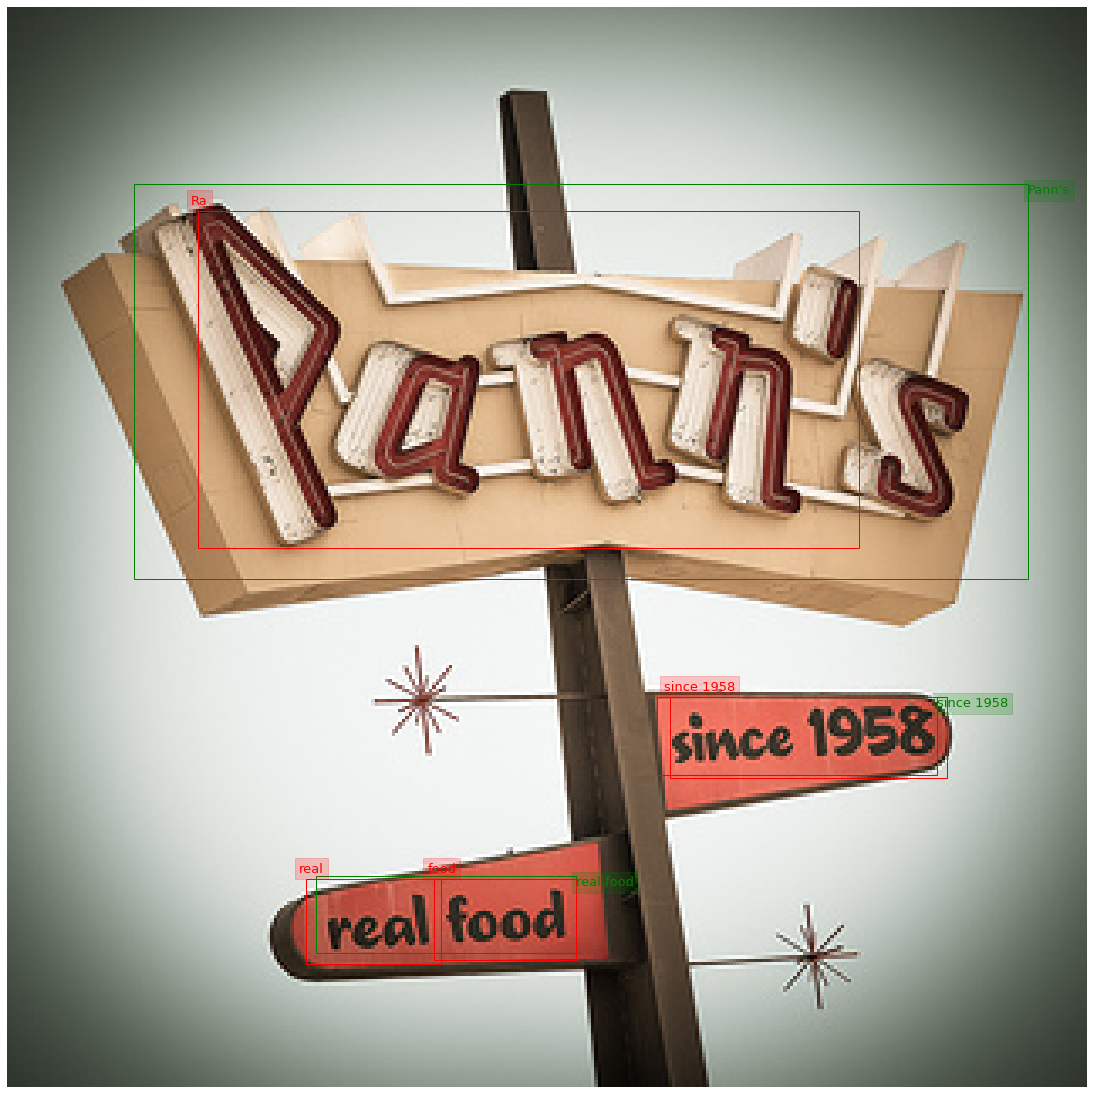

In [74]:
# all images / one sample image
# for i in range(len(images)):
i = 1

im = plot_results(images[i], ground_truth[i], predicted[i])  
im.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

im.savefig('%s/result_%s.png' % (output_dir, file_name))
im.show()
